In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy

### Set up directory
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from tqdm import tqdm
import pickle
import torch
from llama import get_model_and_tokenizer
from ICL import MultiResolutionPDF
from data.serialize import serialize_arr, deserialize_str, SerializerSettings

from scipy.special import erf
from sklearn.preprocessing import MinMaxScaler

import gymnasium as gym

In [2]:
model, tokenizer = get_model_and_tokenizer('7b')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Call llama3 to do predictions

In [3]:
def calculate_multiPDF_llama3(
    full_series,  model, tokenizer, temperature=1.0, number_of_tokens_original=None,
):
    '''
     This function calculates the multi-resolution probability density function (PDF) for a given series.

     Parameters:
     full_series (str): The series for which the PDF is to be calculated.
     prec (int): The precision of the PDF.
     mode (str, optional): The mode of calculation. Defaults to 'neighbor'.
     refine_depth (int, optional): The depth of refinement for the PDF. Defaults to 1.
     llama_size (str, optional): The size of the llama model. Defaults to '13b'.
        
     Returns:
     list: A list of PDFs for the series.
    '''
    good_tokens_str = []
    for num in range(1000):
        good_tokens_str.append(str(num))
    good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]

    batch = tokenizer(
        [full_series],
        return_tensors="pt",
        add_special_tokens=True        
    )

    torch.cuda.empty_cache()
    with torch.no_grad():
        out = model(batch['input_ids'].cuda())  # use_cache=True)
    
    logit_mat = out['logits']
    
    # kv_cache_main = out['past_key_values']
    logit_mat_good = logit_mat[:,:,good_tokens].clone()
    
    if number_of_tokens_original:
        probs = torch.nn.functional.softmax(logit_mat_good[:,-(number_of_tokens_original-1):,:] / temperature, dim=-1)
    else:
        probs = torch.nn.functional.softmax(logit_mat_good[:,1:,:] / temperature, dim=-1)
    
    
    PDF_list = []
    
    # start_loop_from = 1 if use_instruct else 0
    for i in tqdm(range(1,int(probs.shape[1]),2)):
        PDF = MultiResolutionPDF()
        PDF.bin_center_arr = np.arange(0,1000) / 100
        PDF.bin_width_arr = np.array(1000*[0.01])
        PDF.bin_height_arr = probs[0,i,:].cpu().numpy() * 100

        PDF_list.append(PDF)
    
    # release memory
    del logit_mat  #, kv_cache_main
    return PDF_list

## Generate RL series

In [4]:
def serialize_gaussian(prec, time_series, mean_series, sigma_series):
    """
    Serialize a time series with gaussian noise and continuous support.

    Parameters:
    prec (int): Precision of the serialization
    time_series (list): The time series data
    mean_series (list): The mean series data
    sigma_series (list): The sigma series data

    Returns:
    tuple: A tuple containing 
        serialized time series: str
        rescaled mean series: np array
        rescaled sigma series: np array
    """
    settings=SerializerSettings(base=10, prec=prec, signed=True, time_sep=',', bit_sep='', minus_sign='-', fixed_length=False, max_val = 10)
    time_series = np.array(time_series)
    ### Final range is from 0.15 to 0.85
    rescale_factor = 7.0
    up_shift = 1.5

    rescaled_array = (time_series-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift
    rescaled_true_mean_arr = (np.array(mean_series)-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift
    rescaled_true_sigma_arr = np.array(sigma_series)/(time_series.max()-time_series.min()) * rescale_factor 
    # rescaled_true_mean_arr *= 10
    # rescaled_true_sigma_arr *= 10
    full_series = serialize_arr(rescaled_array, settings)
    return (full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr)

## RL helper functions

In [3]:
from rl_utils import gym_generate_random_policy, load_offline_dataset, make_RL_time_serie, icl_prediction, compute_statistics, to_plot_stats 

## Main code

columns: Index(['rootz', 'rooty', 'bthigh', 'bshin', 'bfoot', 'fthigh', 'fshin',
       'ffoot', 'rootx_dot', 'rootz_dot', 'rooty_dot', 'bthigh_dot',
       'bshin_dot', 'bfoot_dot', 'fthigh_dot', 'fshin_dot', 'ffoot_dot',
       'obs_reward', 't_bthigh', 't_bshin', 't_bfoot', 't_fthigh', 't_fshin',
       't_ffoot', 'reward', 'restart', 'epoch_id'],
      dtype='object')
sample before rescale: [[0.07944276]]
sample after rescale: [[1.]]
full_series: 850,820,75
full_series: 850,820,75
number_of_tokens_original: 401


/home/abenechehab/miniforge3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7089.82it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


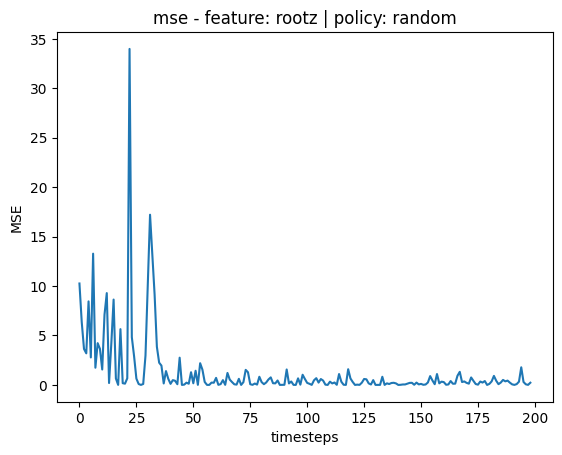

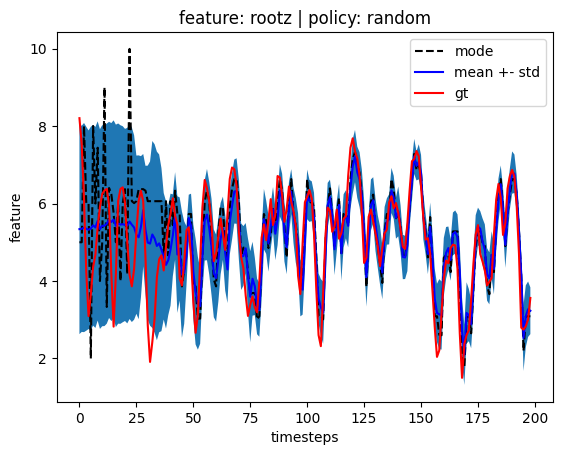

sample before rescale: [[0.05513714]]
sample after rescale: [[0.60450005]]
full_series: 573,533,57
full_series: 573,533,57
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7385.31it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


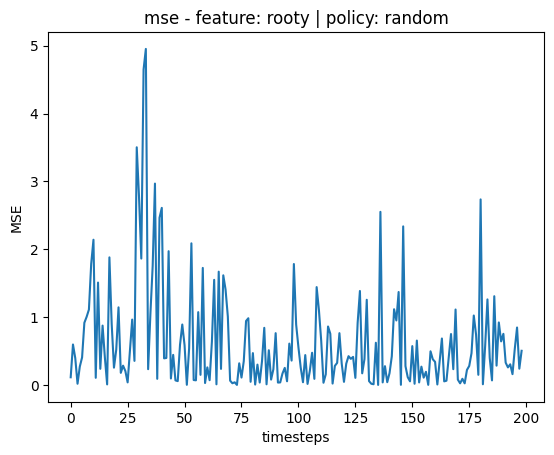

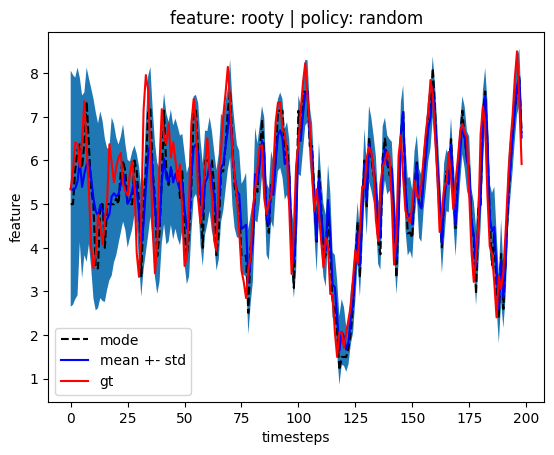

sample before rescale: [[-0.05495856]]
sample after rescale: [[0.39032089]]
full_series: 423,386,43
full_series: 423,386,43
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7200.34it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


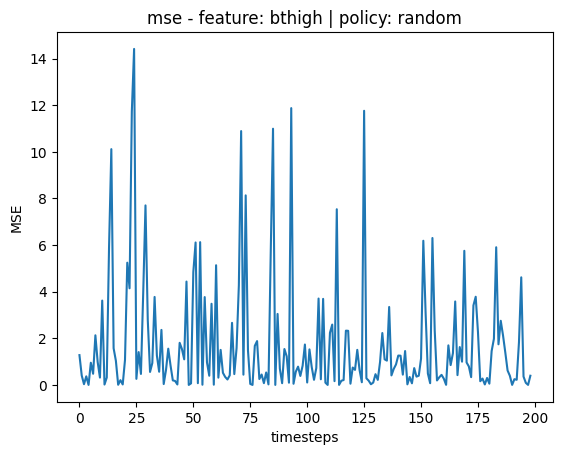

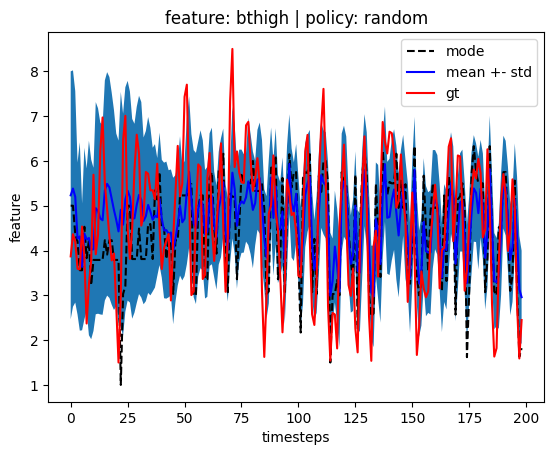

sample before rescale: [[-0.03996674]]
sample after rescale: [[0.50230318]]
full_series: 501,581,49
full_series: 501,581,49
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7364.24it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


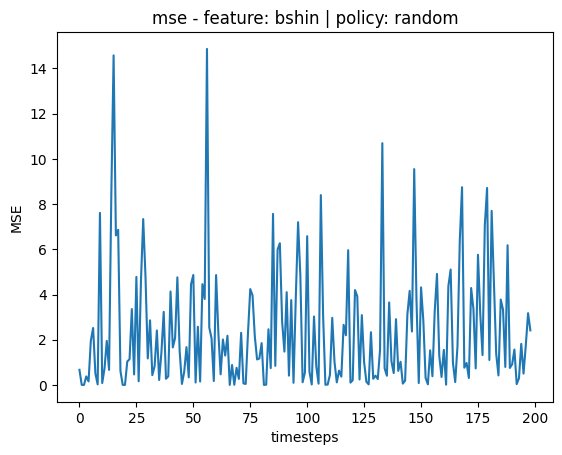

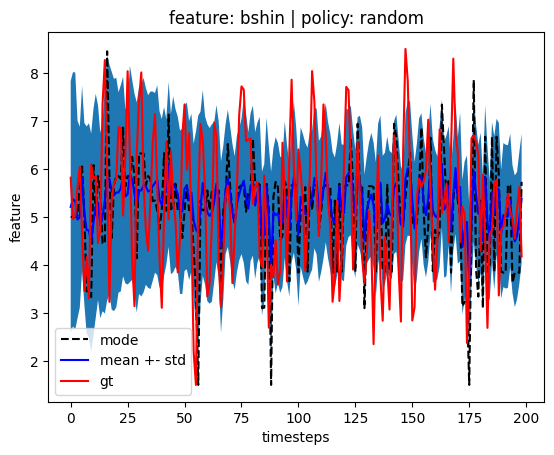

sample before rescale: [[0.07471069]]
sample after rescale: [[0.47486444]]
full_series: 482,681,49
full_series: 482,681,49
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7365.60it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


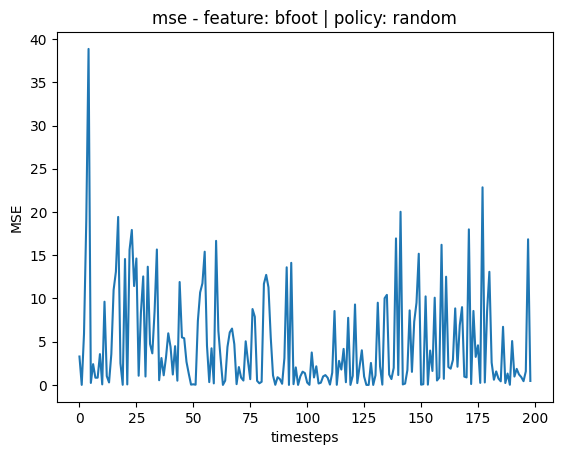

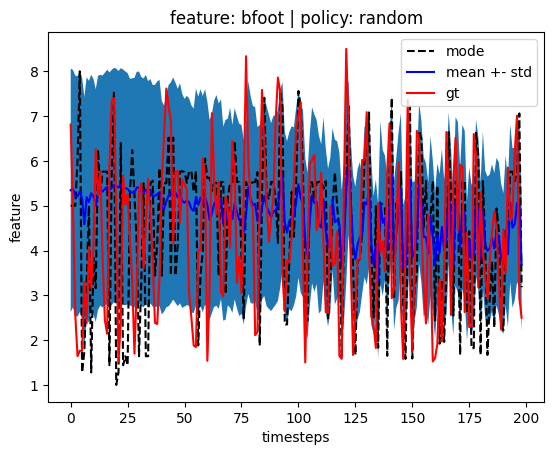

sample before rescale: [[-0.09894694]]
sample after rescale: [[0.43554957]]
full_series: 454,411,45
full_series: 454,411,45
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7375.12it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


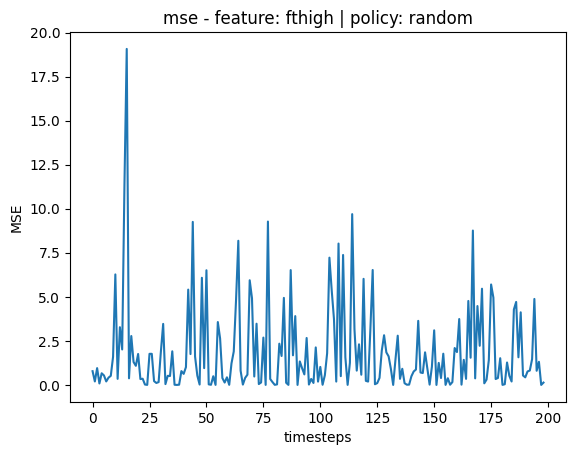

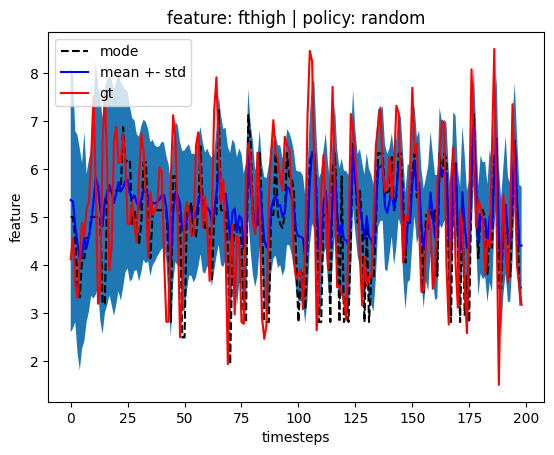

sample before rescale: [[0.06424568]]
sample after rescale: [[0.55133782]]
full_series: 535,678,52
full_series: 535,678,52
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7344.71it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


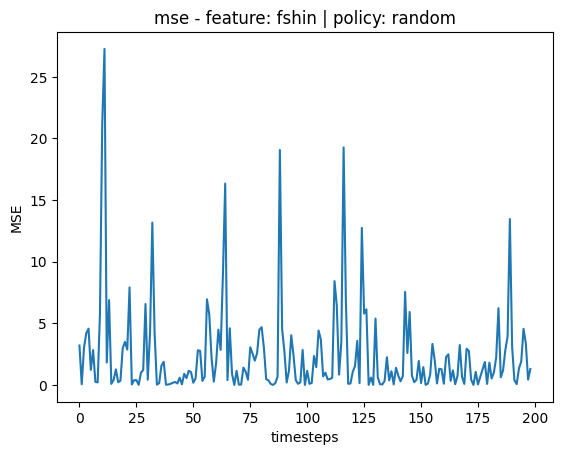

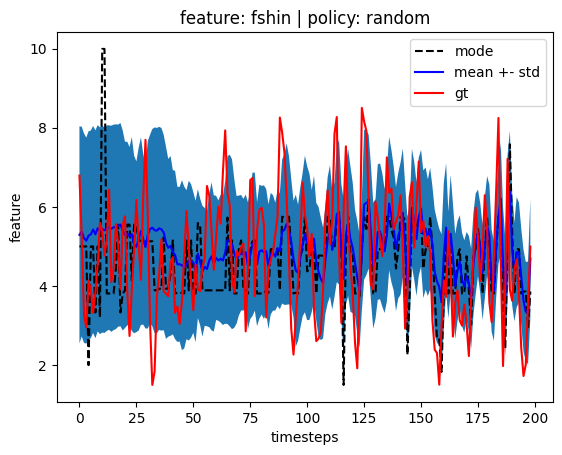

sample before rescale: [[0.05941389]]
sample after rescale: [[0.567566]]
full_series: 547,670,55
full_series: 547,670,55
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7321.37it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


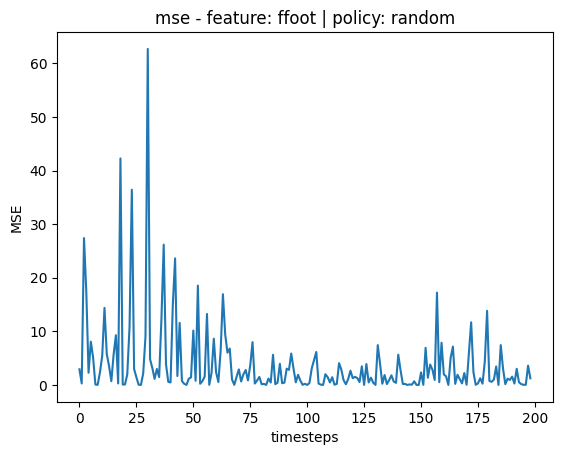

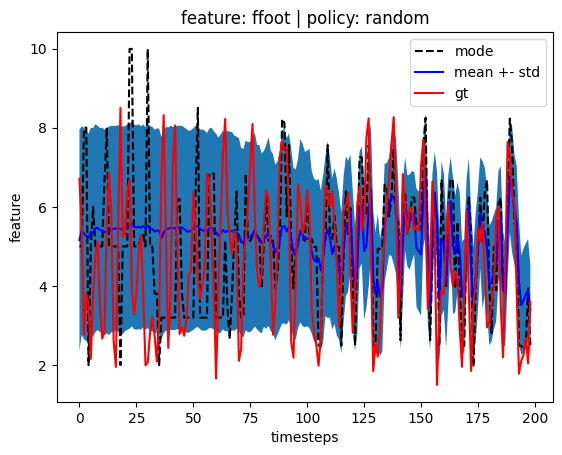

sample before rescale: [[-0.06204749]]
sample after rescale: [[0.55216452]]
full_series: 536,533,54
full_series: 536,533,54
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7380.83it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


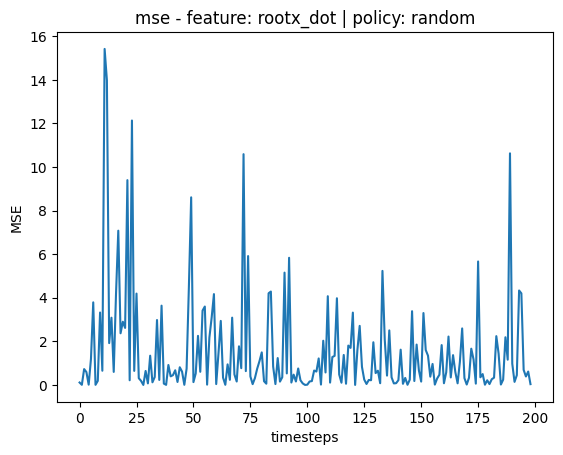

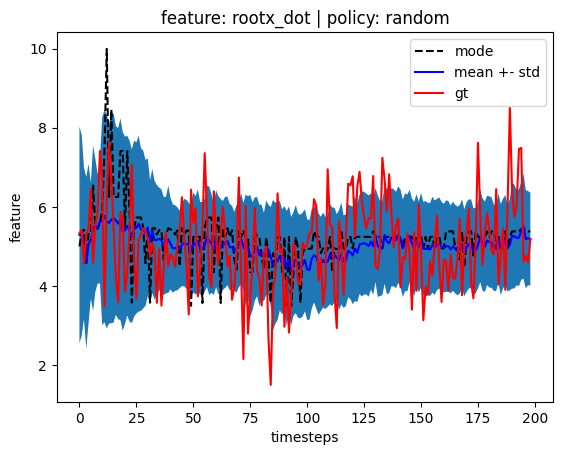

sample before rescale: [[0.04898421]]
sample after rescale: [[0.49345019]]
full_series: 495,404,35
full_series: 495,404,35
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7308.23it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


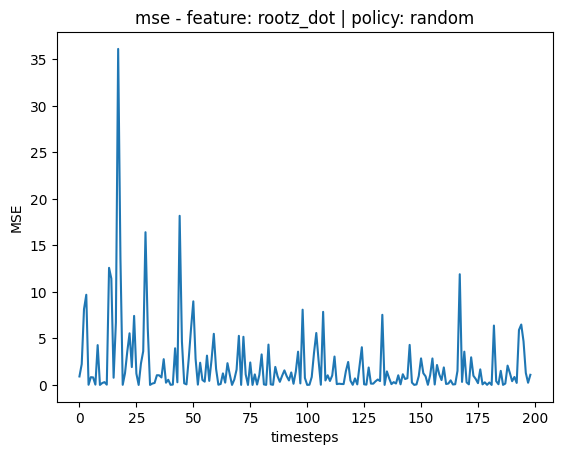

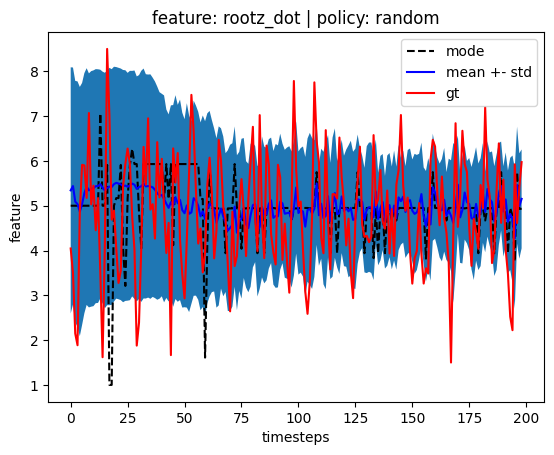

sample before rescale: [[0.0356887]]
sample after rescale: [[0.44171072]]
full_series: 459,383,57
full_series: 459,383,57
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7372.79it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


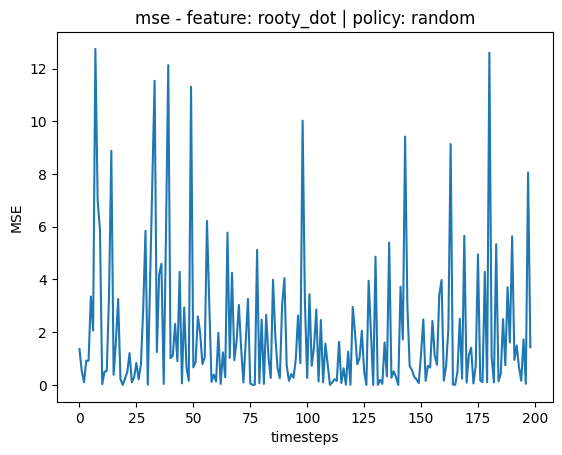

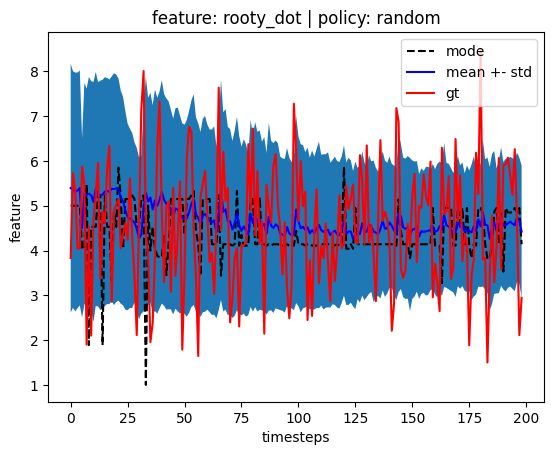

sample before rescale: [[0.01054142]]
sample after rescale: [[0.4928154]]
full_series: 494,460,55
full_series: 494,460,55
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7351.53it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


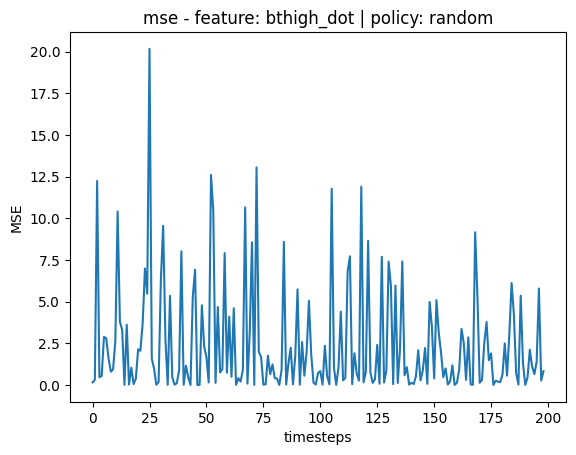

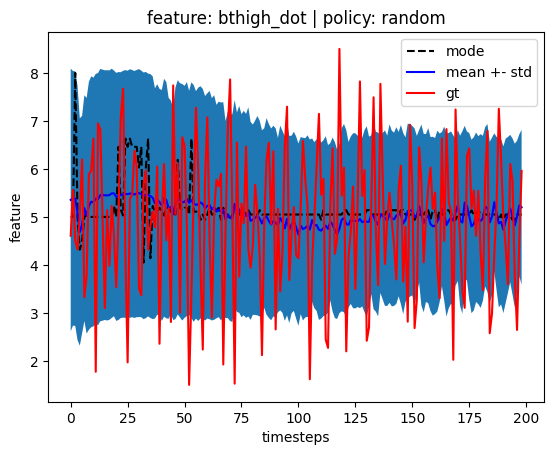

sample before rescale: [[-0.0930468]]
sample after rescale: [[0.43449573]]
full_series: 454,542,31
full_series: 454,542,31
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7337.89it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


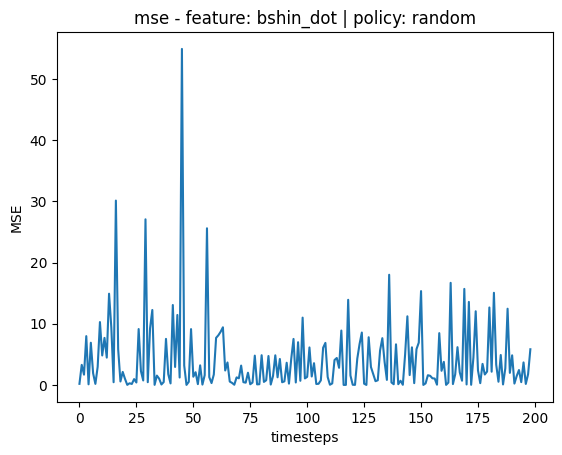

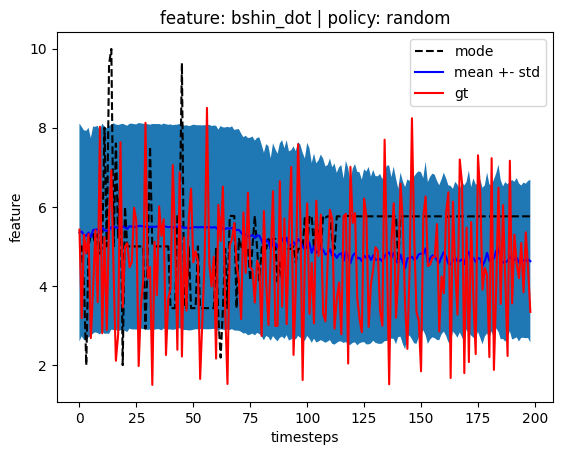

sample before rescale: [[-0.00292518]]
sample after rescale: [[0.55135974]]
full_series: 535,696,30
full_series: 535,696,30
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7290.45it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


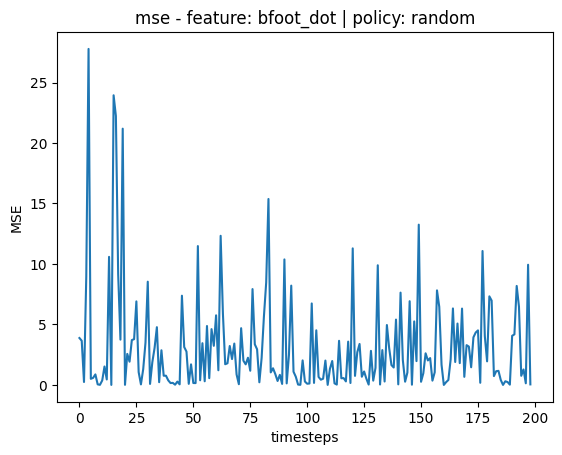

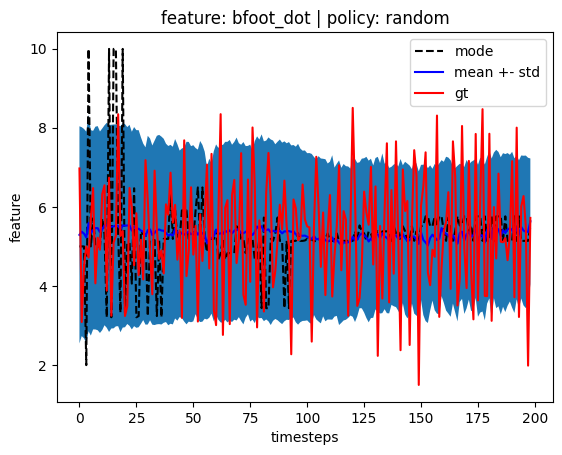

sample before rescale: [[0.06953032]]
sample after rescale: [[0.51990774]]
full_series: 513,475,55
full_series: 513,475,55
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7376.16it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


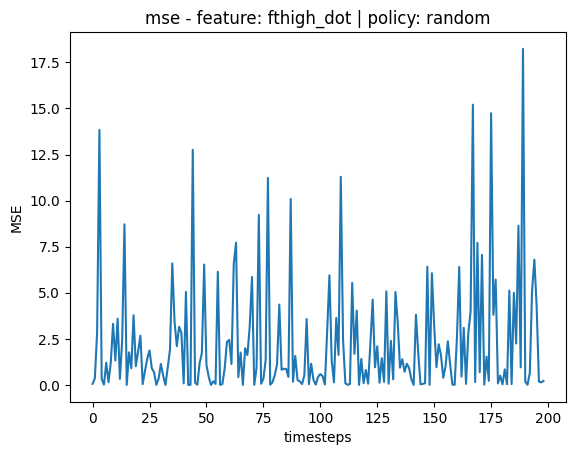

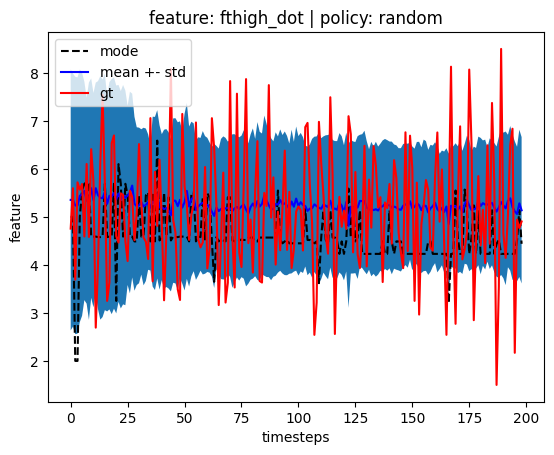

sample before rescale: [[-0.13442145]]
sample after rescale: [[0.55220363]]
full_series: 536,687,31
full_series: 536,687,31
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7316.90it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


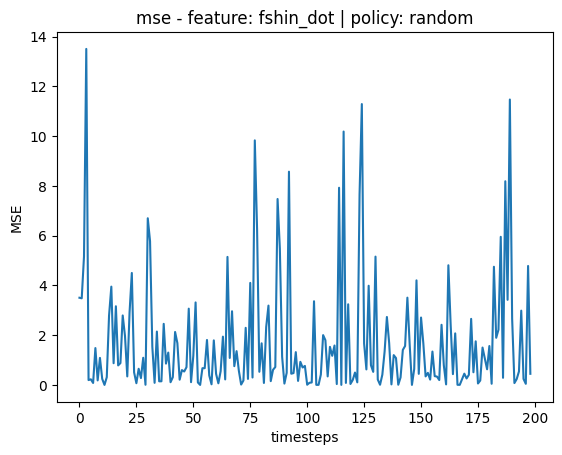

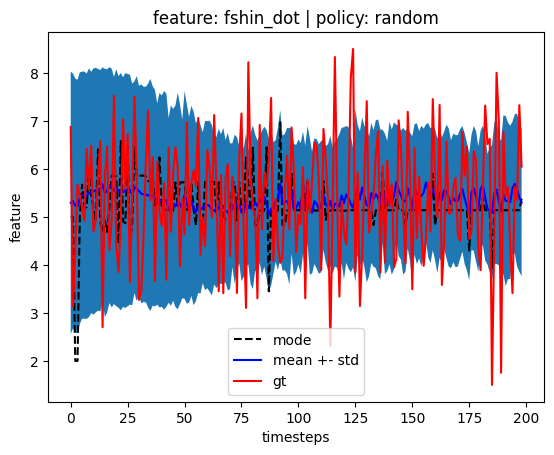

sample before rescale: [[-0.04576158]]
sample after rescale: [[0.51325018]]
full_series: 509,639,31
full_series: 509,639,31
number_of_tokens_original: 401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7317.92it/s]
/tmp/ipykernel_2496796/645425650.py:131: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


mode_arr shape: (199, 1)
time_series_gt shape: (199, 1)


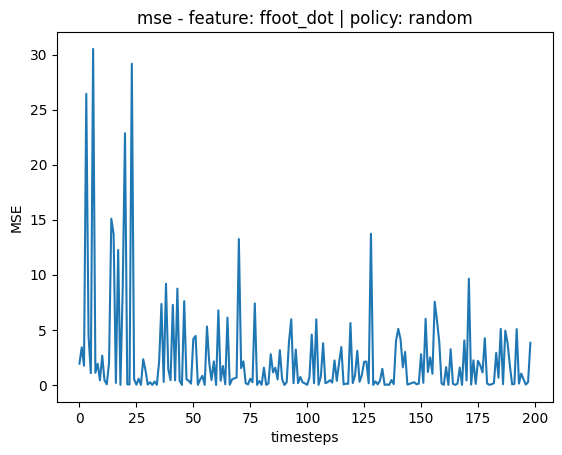

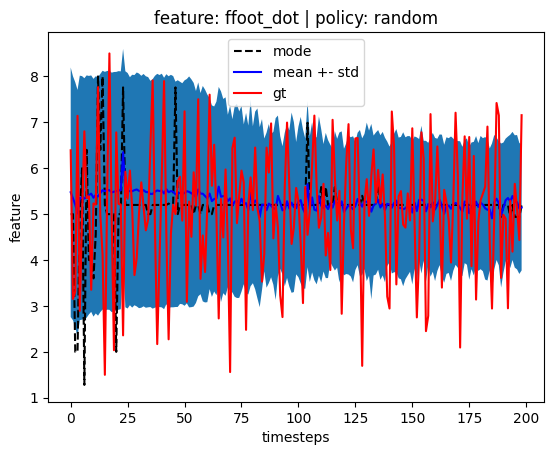

In [46]:
N = 200
env_name = 'HalfCheetah'
policy = 'random'  # 'expert'

# get features names
data_path = "/home/abenechehab/d4rl_halfcheetah/d4rl_expert_80k_20k/X_test.csv"
_, columns, _, _ = load_offline_dataset(path=data_path)
print(f"columns: {columns}")

# -------------------- Build data from env or from offline dataset --------------------
if policy=='random':
    X, N_observations, N_actions = gym_generate_random_policy(Number_of_steps=N, env_name=env_name)
elif policy=='expert':
    X, _, N_observations, N_actions = load_offline_dataset(path=data_path)
    print(f"columns: {columns}")
else:
    raise ValueError(f"policy {policy} not supported!")

dim_list = [0]
dim_list = np.arange(0,17)
all_dim = False
for dim in dim_list:
    # -------------------- Make RL time serie --------------------
    series_dict, N_dim = make_RL_time_serie(
        X=X, 
        N_observations=N_observations, 
        N_actions=N_actions, 
        Number_of_steps=N,
        all_dim=all_dim, 
        dim=dim, 
        add_actions=False, 
        add_reward=False,
        traj_starting_idx=0,
    )
    
    # -------------------- ICL prediction using llama3 --------------------
    series_dict = icl_prediction(series_dict=series_dict, temperature=1.0)
    
    # -------------------- Compute statistics of next state --------------------
    statistics = compute_statistics(
        series_dict=series_dict,
    )
    
    # -------------------- Useful for Plots --------------------
    gt, mode_arr, mean_arr, sigma_arr = to_plot_stats(
        statistics=statistics, series_dict=series_dict, N_dim=N_dim, Number_of_steps=N
    )
    
    # -------------------- MSE --------------------
    mse = (gt - mode_arr)**2
    for feature in range(N_dim):
        plt.figure(1)
        plt.plot(mse[:,feature])
        plt.title(f"mse - feature: {columns[feature] if all_dim else columns[dim]} | policy: {policy}")
        plt.xlabel("timesteps")
        plt.ylabel("MSE")
        plt.savefig(f"RL_figures/mse_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
        plt.show()
    
    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr.shape[0])
    for feature in range(N_dim):
        plt.figure(2)
        plt.plot(x, mode_arr[:,feature], 'k--',label='mode')
        plt.plot(x, mean_arr[:,feature], label='mean +- std', color='blue')
        plt.fill_between(x=x, y1=mean_arr[:,feature]-sigma_arr[:,feature], y2=mean_arr[:,feature]+sigma_arr[:,feature])
        plt.plot(x, gt[:,feature], label='gt', color='red')
        plt.title(f"feature: {columns[feature] if all_dim else columns[dim]} | policy: {policy}")
        plt.xlabel("timesteps")
        plt.ylabel("feature")
        plt.legend()
        plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
        plt.show()

In [2]:
import gymnasium as gym
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env.reset()

(0, {'prob': 1})

(8, 0.0, False, False, {'prob': 0.3333333333333333})